# Neuron fate prediction from combinatorial morphogen treatment

In this notebook, we show how {class}`~cellflow.model.CellFlow` can be used to predict the outcome of **neuron fate programming experiments**. We use the the dataset from [Lin, Janssens et al.](https://www.biorxiv.org/content/10.1101/2023.12.12.571318v2), which contains scRNA-seq data from an morphogen screen in NGN2-induced neurons (iNeurons). The treatment conditions comprised combinations of modulators of anterior-posterior (AP) patterning (RA, CHIR99021, XAV-939, FGF8) with modulators of dorso-ventral (DV) patterning (BMP4, SHH), each applied in multiple concentrations. We use CellFlow to predict neuron distributions for held-out combinations of morphogens. 

## Preparing the data

In [ ]:
from functools import partial

import anndata as ad
import flax.linen as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import umap
from ott.solvers import utils as solver_utils
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

import cellflow
import cellflow.preprocessing as cfpp

In [2]:
adata = cellflow.datasets.ineurons()
print(adata)

AnnData object with n_obs × n_vars = 178437 × 4000
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_well', 'bc2_well', 'bc3_well', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'plateID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'percent_mito', 'n_counts', 'outlier', 'mt_outlier', 'doublet_score', 'predicted_doublet', 'leiden_4', 'leiden_10', 'merged_clusters', 'final_clustering', 'final_clustering_reset', 'merged_clusters_from_10', 'M_XAV', 'M_CHIR', 'M_RA', 'M_FGF8', 'M_BMP4', 'M_SHH', 'M_PM', 'media', 'sample-CellID', 'Neuron_type', 'Division', 'Region', 'FGF8_conc', 'FGF8_start_time', 'FGF8_end_time', 'XAV_conc', 'XAV_start_time', 'XAV_end_time', 'RA_conc', 'RA_start_time', 'RA_end_time', 'CHIR_conc', 'CHIR_start_time', 'CHIR_end_time', 'SHH_conc', 'SHH

### Encoding of morphogen treatment conditions
Now we need to create **representations for the perturbation conditions** to be used by CellFlow. For this, we us a one-hot encoding of the morphogen multiplied by the concentration, which we store in `adata.uns["conditions"]`. We also create columns in the adata object, indicating the treatment conditions for each cell.

In [3]:
morphogens = ["FGF8", "XAV", "RA", "CHIR", "SHH", "BMP4"]
dataset_enc = OneHotEncoder()
dataset_enc.fit(np.array(morphogens).reshape(-1, 1))
condition_dict = {}
condition_keys = []

for mol in morphogens:
    mol_onehot = (
        dataset_enc.transform(np.array([mol]).reshape(-1, 1)).toarray().flatten()
    )
    concs = adata.obs[mol + "_conc"].unique()
    for conc in concs:
        cond_cells = adata.obs[mol + "_conc"] == conc
        cond_id = mol + "_" + str(conc)
        if cond_id in condition_keys:
            continue
        condition_keys.append(cond_id)
        adata.obs[cond_id] = cond_cells
        condition_dict[cond_id] = mol_onehot * np.log1p(float(conc))

adata.uns["conditions"] = condition_dict
print(adata)

AnnData object with n_obs × n_vars = 178437 × 4000
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_well', 'bc2_well', 'bc3_well', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'plateID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'percent_mito', 'n_counts', 'outlier', 'mt_outlier', 'doublet_score', 'predicted_doublet', 'leiden_4', 'leiden_10', 'merged_clusters', 'final_clustering', 'final_clustering_reset', 'merged_clusters_from_10', 'M_XAV', 'M_CHIR', 'M_RA', 'M_FGF8', 'M_BMP4', 'M_SHH', 'M_PM', 'media', 'sample-CellID', 'Neuron_type', 'Division', 'Region', 'FGF8_conc', 'FGF8_start_time', 'FGF8_end_time', 'XAV_conc', 'XAV_start_time', 'XAV_end_time', 'RA_conc', 'RA_start_time', 'RA_end_time', 'CHIR_conc', 'CHIR_start_time', 'CHIR_end_time', 'SHH_conc', 'SHH

### Train / test split
Now we split the data into **train in test set**. We know from the original study that RA+BMP4 is a particularly interesting combination, as it resulted in new cell states that were not seen with any individual morphogen treatment. We now want to test wether CellFlow can predict these new cell states by holding out all conditions including the combination of RA+BMP4 from training. 

In [ ]:
exclude_combs = ["RA+BMP4", "RA+CHIR+BMP4"]
adata_train = adata[
    ~adata.obs["comb"].isin(exclude_combs)
]
adata_eval = adata[
    adata.obs["comb"].isin(exclude_combs)
]

To prevent any leakage of information by having a latent space computed with the held-out conditions, we also we recompute PCA for the trainign set only and then project the test set into this space.

In [5]:
cfpp.centered_pca(adata_train, n_comps=30, method="rapids")
cfpp.project_pca(adata_eval, adata_train)

### Generating a source distribution
To train the model and generate predictions, we also need a **source distribution** to generate from. In most other use cases, we can just use the control condition for his. However, in this case, each condition (including the lack of morphogens) generates distinct cell state distributions. This means that the control condition cannot be viewed as an "unperturbed" state and it therefore does not necessarily make sense to use it as a source distribution. Instead, we use a random distribution that is generated from subsamples means of the training data. As a result, the model will essentially act in a fully generative way, generating new cell distributions from a random source.

In [6]:
n_src_cells = 10000
n_samples = 1000
sample_rep = "X_pca"
samples = []
for i in range(n_src_cells):
    sample = adata_train.obsm[sample_rep][
        np.random.choice(adata_train.n_obs, n_samples), :
    ].mean(axis=0)
    samples.append(sample)
samples = np.array(samples)
samples_obs = pd.DataFrame(
    {col: 0.0 for col in [mol + "_conc" for mol in morphogens]},
    index=range(samples.shape[0]),
)
samples_obs["dataset"] = "CTRL"
samples_obs["media"] = "CTRL"
samples_obs["condition"] = "CTRL"
adata_ctrl = sc.AnnData(
    X=csr_matrix(np.zeros((samples.shape[0], adata_train.n_vars))), obs=samples_obs
)
adata_ctrl.obsm[sample_rep] = samples
adata_ctrl.var_names = adata_train.var_names
adata_train_full = ad.concat([adata_train, adata_ctrl], join="outer")
adata_train_full.obs["CTRL"] = adata_train_full.obs["dataset"] == "CTRL"
adata_ctrl.obs["CTRL"] = True
adata_train_full.uns, adata_eval.uns = adata.uns, adata.uns

## Running CellFlow
Now we are ready to set up the `CellFlow` model. We use the default deterministic `otfm` solver for this task.

In [7]:
cf = cellflow.model.CellFlow(adata_train_full, solver="otfm")

### Preparing CellFlow’s data handling with {meth}`~cellflow.model.CellFlow.prepare_data`
We set up the data as follows:
- We use `.obsm["X_pca"]` as the cellular representation (`sample_rep`)
- `"CTRL"` indicated the source distribution we constructed earlier
- We use the previously constructed columns indicating morphogen concentrations as `perturbation_covariates`
- As representations for the perturbation conditions, we use the one-hot encoded morphogen concentrations in `.uns["conditions"]` (`perturbation_covariate_reps`).

In [8]:
cf.prepare_data(
    sample_rep=sample_rep,
    control_key="CTRL",
    perturbation_covariates={"conditions": condition_keys},
    perturbation_covariate_reps={"conditions": "conditions"},
)

100%|██████████| 169/169 [00:03<00:00, 53.24it/s]


### Preparing CellFlow’s model architecture with {meth}`~cellflow.model.CellFlow.prepare_model`
Now we can set up the architecture of the CellFlow model. For a detailed description of all hyperparameters, please have a look at {meth}`~cellflow.model.CellFlow.prepare_model` or {doc}`100_pbmc`. 

While there is some intuition behind which parameter settings to use, we generally we use hyperparameter optimization on a separate validation set to find the best hyperparameters for each task. These are some of the most relevant parameters for this task:

- `layers_before_pool` and `layers_after_pool` define the networks before and after permutation-invariant pooling of combinatorial conditions. Here, we only define a network before pooling to encode the one-hot-encoded morphogen representations and no `layers_after_pool` to use only one layer to transform the pooled representation into the condition embedding.
- We found that that pooling the combinations by their mean (`pooling_type="mean"`) works best for this task. This might be due to the fact that the morphogen combination conditions are *relatively* simple and their total number is somewhat small, which might make it harder to learn a more complex attention-based pooling.
- `match_fn` defines how to sample pairs between the source and the perturbed cells. Here, the source distribution is a random distribution rather than a control condition, but because the output distributions are relatively complex an might contain outliers, we still found some unbalancedness to be useful for this task, so we se `tau_a=tau_b=0.99`.
- `flow` defines the reference vector field between pairs of samples which the {class}`~cellflow.networks._velocity_field.ConditionalVelocityField` is regressed against. We don't use any noise here as our cell population is highly heterogenous.
- We found that sometimes the relationship between sizes of the condition embedding as well as encoded `x`, and `time` in the {class}`~cellflow.networks._velocity_field.ConditionalVelocityField` can matter quite a bit to the model. We are not sure exactly why this is tha case, but we found it to be especially important for iNeuron and organoid applications, where we generate from noise into a complex output distribution. We therefore set the `hidden_dims=[2048] * 2 + [128]` to transform the `x` embedding into a smaller dimension with the last layer.

In [9]:
layers_before_pool = [{
    "layer_type": "mlp",
    "dims": [2048] * 4,
    "dropout_rate": 0.0,
    "act_fn": nn.relu,
}]
layers_after_pool = []

In [10]:
match_fn = partial(
    solver_utils.match_linear,
    epsilon=0.5,
    scale_cost="mean",
    tau_a=0.99,
    tau_b=0.99,
)

In [11]:
cf.prepare_model(
    condition_embedding_dim=128,
    time_encoder_dims=[1024] * 5,
    time_encoder_dropout=0.1,
    hidden_dims=[2048] * 2 + [128],
    hidden_dropout=0.2,
    decoder_dims=[512] * 2,
    decoder_dropout=0.1,
    pooling="mean",
    layers_before_pool=layers_before_pool,
    layers_after_pool=layers_after_pool,
    cond_output_dropout=0.3,
    flow={"constant_noise": 0.0},
    match_fn=match_fn
)

Now we can train the model. To make training quicker, we here don't compute validation metrics during training, but only evaluare predictions afterwards. If you are running a model for the fist time, we recommend to monitor training behaviour with validation data through {meth}`~cellflow.model.CellFlow.prepare_validation_data` as explained in {doc}`100_pbmc`.

In [15]:
cf.train(num_iterations=500000)

100%|██████████| 500000/500000 [3:44:15<00:00, 37.16it/s, loss=0.969]  


After training, we can save the model to disk with {meth}`~cellflow.model.CellFlow.save_model` and load it again with {meth}`~cellflow.model.CellFlow.load_model`. 

In [ ]:
cf.save("cellflow_model/", overwrite=True)
cf = cellflow.model.CellFlow.load(
    "cellflow_model/"
)

### Making predictions
Now we can finally check out the predictions. we use {meth}`~cellflow.model.CellFlow.predict` to generate predictions for the held-out conditions in the validation dataset.

In [15]:
adata_ctrl.uns = adata.uns
obs_pred = adata_eval.obs.drop_duplicates("condition")

x_pred = cf.predict(
    adata_ctrl,
    sample_rep=sample_rep,
    covariate_data=obs_pred,
    condition_id_key="condition",
)

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:00<00:00, 92.81it/s]


{meth}`~cellflow.model.CellFlow.predict` returns a dictionaly with predictions for each condition. We now convert the predictions into an {class}`adata <anndata.AnnData>` object.

In [16]:
adatas_pred = []
for condition in x_pred.keys():
    adata_pred = ad.AnnData(X=adata_ctrl.X)
    adata_pred.obs["comb"] = adata_eval.obs["comb"][
        adata_eval.obs["condition"] == condition
    ].values[0]
    adata_pred.obs["condition"] = condition
    adata_pred.obsm[sample_rep] = x_pred[condition]
    adatas_pred.append(adata_pred)

adata_pred = ad.concat(adatas_pred, join="outer")

To obtain gene expression values for our predictions, we use {meth}`cellflow.preprocessing.reconstruct_pca` to reconstruct the PCA space where the predictions were made. We then reproject the predictions into a new PCA space with the full ground truth data. 

In [17]:
cfpp.reconstruct_pca(adata_pred, use_rep="X_pca", ref_adata=adata_train)
adata_pred.X = csr_matrix(adata_pred.layers["X_recon"])
del adata_pred.layers["X_recon"]

cfpp.centered_pca(adata, n_comps=30, method="rapids")
cfpp.project_pca(adata_pred, adata, obsm_key_added="X_pca_reproj")

To visualize the predictions, we can use UMAP. We first compute an embedding from the full dataset and then project the predictions onto it.

In [20]:
umap_model = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    n_epochs=500,
    learning_rate=1.0,
    init="spectral",
    min_dist=0.4,
    spread=1.0,
    negative_sample_rate=5,
    a=None,
    b=None,
    random_state=212,
    n_jobs=-1,
)
adata.obsm["X_umap"] = umap_model.fit_transform(adata.obsm["X_pca"])
adata_pred.obsm["X_umap"] = umap_model.transform(adata_pred.obsm["X_pca_reproj"])

We plot the ground truth populations of the held out combination as well as the individual morphogen treatments alongside the predictions. We also subsample the predictions a bit, to make the plot clearer.

In [30]:
adata_pred

AnnData object with n_obs × n_vars = 240000 × 4000
    obs: 'comb', 'condition'
    obsm: 'X_pca', 'X_pca_reproj', 'X_umap'

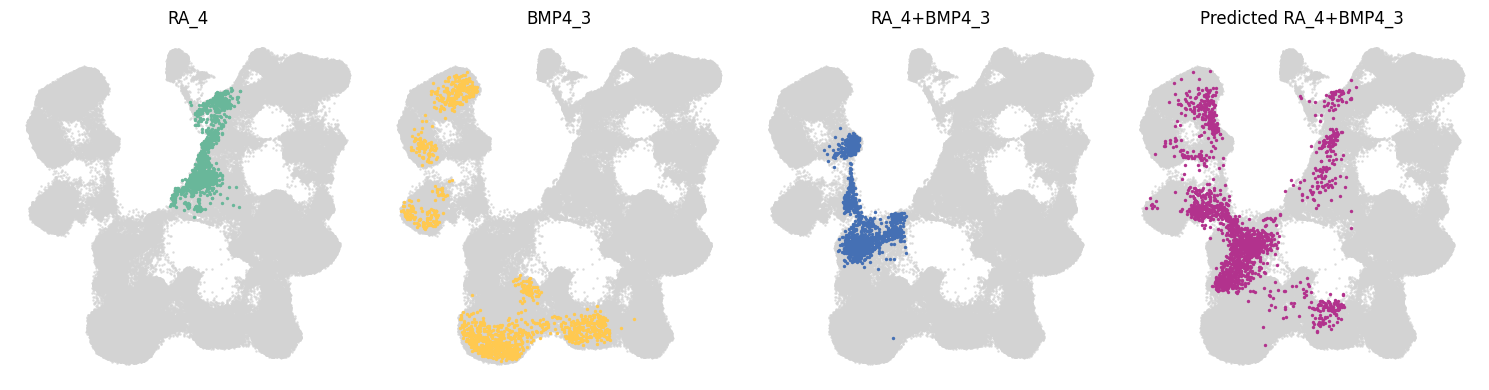

In [38]:
adata_pred_plot = adata_pred[adata_pred.obs["condition"] == "RA_3+BMP4_3"]
adata_pred_plot = adata_pred_plot[
    np.random.choice(
        adata_pred_plot.n_obs, 2000, replace=False
    )
]

adatas_plot = [
    adata[adata.obs["condition"] == "RA_4"],
    adata[adata.obs["condition"] == "BMP4_3"],
    adata[adata.obs["condition"] == "RA_4+BMP4_3"],
    adata_pred_plot,
]
titles = ["RA_4", "BMP4_3", "RA_4+BMP4_3", "Predicted RA_4+BMP4_3"]
colors = ["#69B79A", "#FFC950", "#4570B4", "#B2328D"]
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
for i, (adata_plot, title) in enumerate(zip(adatas_plot, titles)):
    ax = axs.flatten()[i]
    sns.scatterplot(
        x=adata.obsm["X_umap"][:, 0],
        y=adata.obsm["X_umap"][:, 1],
        c="lightgrey",
        s=3,
        alpha=0.8,
        linewidth=0,
        rasterized=True,
        ax=ax,
    )
    sns.scatterplot(
        x=adatas_plot[i].obsm["X_umap"][:, 0],
        y=adatas_plot[i].obsm["X_umap"][:, 1],
        s=6,
        linewidth=0,
        color=colors[i],
        rasterized=True,
        ax=ax,
    )
    ax.set_title(title)
    ax.axis("off")
plt.tight_layout()
plt.show()

We can see the our predictions are pretty close to the actual population. Most importantly, the preditions reflect new cell states that were not seen in the individual morphogen treatments. We can also inspect the predictions through looking at marginal distributions on principal components. The can give some insight into how cell distributions are predicted.

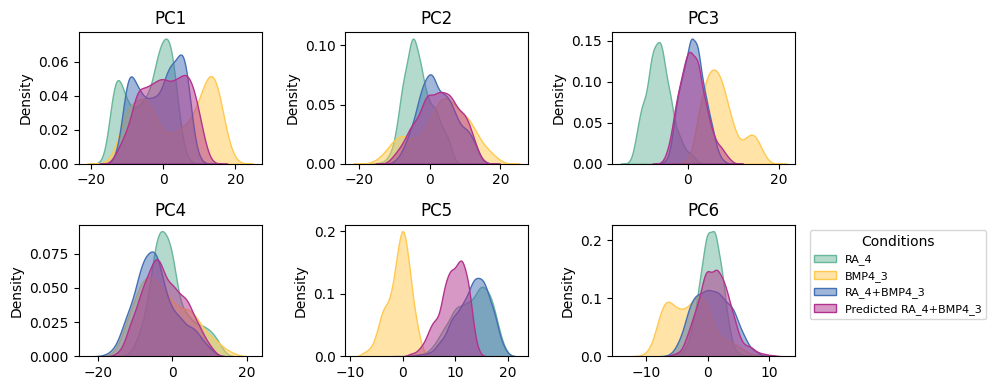

In [60]:
fig, axs = plt.subplots(2, 3, figsize=(10, 4))
for i, ax in enumerate(axs.flatten()):
    sns.kdeplot(
        x=adata[adata.obs["condition"] == "RA_4"].obsm["X_pca"][:, i],
        fill=True,
        levels=10,
        color=colors[0],
        label="RA_4",
        alpha=0.5,
        ax=ax,
    )
    sns.kdeplot(
        x=adata[adata.obs["condition"] == "BMP4_3"].obsm["X_pca"][:, i],
        fill=True,
        levels=10,
        color=colors[1],
        label="BMP4_3",
        alpha=0.5,
        ax=ax,
    )
    sns.kdeplot(
        x=adata[adata.obs["condition"] == "RA_4+BMP4_3"].obsm["X_pca"][:, i],
        fill=True,
        levels=10,
        color=colors[2],
        label="RA_4+BMP4_3",
        alpha=0.5,
        ax=ax,
    )
    sns.kdeplot(
        x=adata_pred_plot.obsm["X_pca_reproj"][:, i],
        fill=True,
        levels=10,
        color=colors[3],
        label="Predicted RA_4+BMP4_3",
        alpha=0.5,
        ax=ax,
    )
    ax.set_title("PC" + str(i + 1))
plt.legend(
    loc="best",
    bbox_to_anchor=(1.05, 1),
    fontsize=8,
    title="Conditions",
    title_fontsize=10,
)
plt.tight_layout()
plt.show()

We can see here quite clearly (e.g. on PC3) that the true combinatorial distribution is actually a intermediate distribution between individual treatments and that dis distribution is prediceted well by CellFlow.